In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import seaborn as sns
#import GMM
from statsmodels.sandbox.regression.gmm import GMM, NonlinearIVGMM, LinearIVGMM
import statsmodels.api as sm
#set seaborn graphics
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
pathdata = os.getcwd()+'/Data'
os.chdir(pathdata)
df_infl = pd.read_pickle('infl_data.pkl')
df_infl.index = df_infl['SurveyDate']
df_infl = df_infl.drop('SurveyDate', axis=1)

# load shocks

In [3]:
oisfactors = pd.read_csv('dataset_con.csv')
oisfactors.index = pd.to_datetime(oisfactors['Date'])
oisfactors

,1M,3M,6M,1Y,2Y,5Y,10Y,Date,ConfFactor1,ConfFactor2,ConfFactor3
Date,,,,,,,,,,,
2002-01-03,0.0125,0.0125,0.0070,0.00500,-0.0050,-0.0105,-0.0140,2002-01-03,1.984610,-2.013147,-0.765204
2002-02-07,0.0050,0.0080,0.0050,0.01250,0.0145,0.0240,0.0210,2002-02-07,0.803178,0.588936,1.714052
2002-03-07,0.0050,0.0000,0.0020,-0.00500,-0.0050,0.0025,0.0025,2002-03-07,0.502155,-0.819328,0.754432
2002-04-04,-0.0075,-0.0125,-0.0100,-0.02250,-0.0300,-0.0240,-0.0230,2002-04-04,-0.944470,-1.100228,-1.087792
2002-05-02,0.0050,0.0200,0.0425,0.07000,0.0725,0.0615,0.0530,2002-05-02,2.389232,4.821021,1.451719
...,...,...,...,...,...,...,...,...,...,...,...
2018-03-08,-0.0018,0.0000,0.0040,-0.00175,-0.0077,-0.0258,-0.0290,2018-03-08,0.332580,-0.231835,-2.799684
2018-04-26,0.0000,0.0000,0.0000,-0.00100,-0.0030,0.0000,0.0030,2018-04-26,0.271545,-0.314816,0.421258
2018-06-14,0.0000,0.0000,0.0000,0.00000,-0.0040,-0.0080,-0.0050,2018-06-14,0.304379,-0.304242,-0.458284


In [4]:
#End of period DEFINITION - always take the last shock
mpdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Monetary Event Window')
mpdf.index = mpdf['date']
prdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Release Window')
prdf.index = prdf['date']
pcdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Conference Window')
pcdf.index = pcdf['date']
pcdf = pd.concat([pcdf, oisfactors], axis = 1)


# some useful functions

In [5]:
def get_diff_dataframe(df):
    for eachcol in df.columns.to_list()[1:]:
        df[eachcol] = df[eachcol].astype(float)  
    return df.groupby(['Source', 'SurveyDate']).mean().sort_index().diff()

In [32]:
def cumSums(results, first_element = 0):
    cumsumCI = np.zeros((8, 3))
    #first estimate c0
    samplesize = 47
    mean = results.params[first_element] 
    cov = results.cov_params()[first_element,first_element]*samplesize
    upB = mean + 1.96*np.sqrt(cov)/np.sqrt(47)
    lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(47)
    cumsumCI[0, 0] = lowB
    cumsumCI[0, 1] = mean
    cumsumCI[0, 2] = upB
    #we continue for the other coefficients
    for i in range(first_element+1, first_element+8):
        #get the new mean
        mean = mean + results.params[i]
        #add the variance
        cov = cov + results.cov_params()[i,i]*samplesize
        #add the covariances
        for j in range(first_element, i):
            cov = cov + 2*results.cov_params()[j,i]*samplesize
        upB = mean + 1.96*np.sqrt(cov)/np.sqrt(47)
        lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(47)
        cumsumCI[i-first_element, 0] = lowB
        cumsumCI[i-first_element, 1] = mean
        cumsumCI[i-first_element, 2] = upB

    df = pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB'])
    df = df.sort_index()
    plt.plot(df['Mean'], color='r');
    plt.fill_between(df.index, df['LowerB'], df['Mean'], alpha = 0.1, color='darkslategrey')
    plt.fill_between(df.index, df['UpperB'], df['Mean'], alpha = 0.1, color='darkslategrey')
    plt.title('Inflation');

# transforming SPF data

In [7]:
df = get_diff_dataframe(df_infl).reset_index()

In [8]:
df.index = df['SurveyDate']
df = df.sort_index()

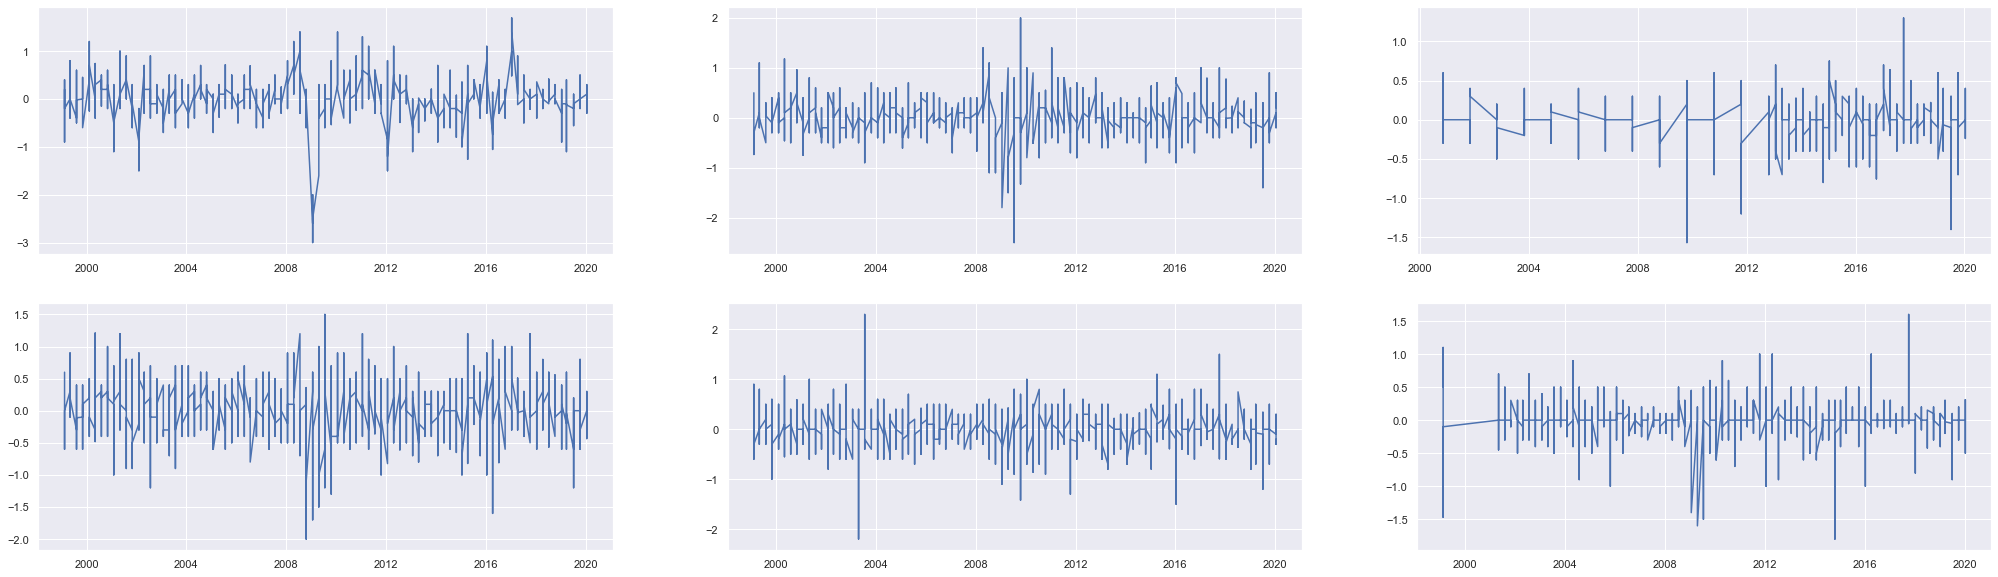

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(35, 10));
axs[0,0].plot(df['Current Year'].dropna().astype(float))
axs[0,1].plot(df['One Year Ahead'].dropna().astype(float))
axs[0,2].plot(df['Two Years Ahead'].dropna().astype(float))
axs[1,0].plot(df['Rolling1'].dropna().astype(float))
axs[1,1].plot(df['Rolling2'].dropna().astype(float))
axs[1,2].plot(df['Longer Term'].dropna().astype(float));

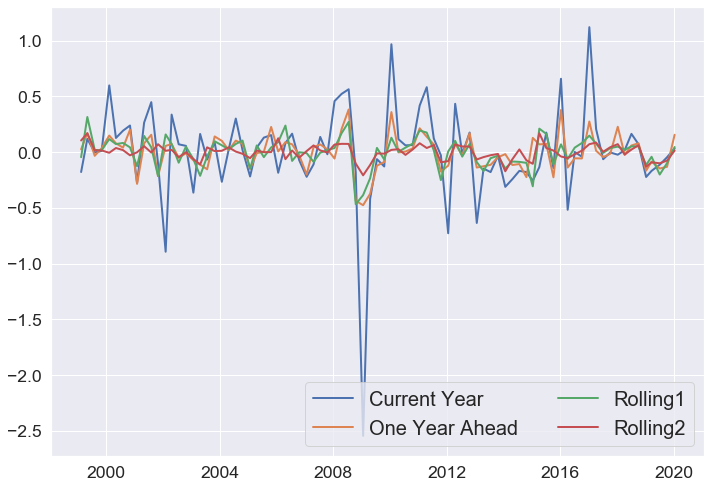

In [10]:
df = df.drop('SurveyDate', axis = 1)
dfmeans = df.groupby('SurveyDate')[['Current Year','One Year Ahead', 'Rolling1', 'Rolling2']].mean()

sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.6);
plt.plot(dfmeans, linewidth=2.0);
plt.legend(list(dfmeans), ncol=2, loc='lower right', fontsize=20);

## GMM framework

In [52]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7 = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        #endogenous variables
        currentY = endog[:,0]
        nextY = endog[:,1]
        rolling1 = endog[:,2]
        rolling2 = endog[:,3]
        #monetary policy shock
        mp = exog[:,4]
        #next year forecasts
        error1 = dQ1*mp*(nextY-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7)*dQ1)
        error2 = dQ2*mp*(nextY-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6)*dQ2)
        error3 = dQ3*mp*(nextY-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5)*dQ3)
        error4 = dQ4*mp*(nextY-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4)*dQ4)
        #current year forecasts
        error5 = dQ1*mp*(currentY-mp*(c0+3/4*c1+1/2*c2+1/4*c3)*dQ1)
        error6 = dQ2*mp*(currentY-mp*(3/4*c0+1/2*c1+1/4*c2)*dQ2)
        error7 = dQ3*mp*(currentY-mp*(1/2*c0+1/4*c1)*dQ3)
        error8 = dQ4*mp*(currentY-mp*(1/4*c0)*dQ4)
        #rolling forecasts
        error9 = mp*(rolling1-mp*(c0+c1+c2+c3))
        error10 = mp*(rolling2-mp*(c4+c5+c6+c7))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error7, error8, error9, error10))
        return g

#order data
dataols = pd.merge_asof(dfmeans, pcdf, left_index=True, right_index = True,
                       direction='backward')
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var])
#time periods
dataols = dataols.loc[(dataols.index>'2002-01-01')&(dataols.index<'2014-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1
exog = dataols[['D1', 'D2', 'D3', 'D4', var]]
endog = dataols[['Current Year', 'One Year Ahead', 'Rolling1', 'Rolling2']].copy()
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 8))
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='hac',
                  wargs={'maxlag':4})

w0 = res[1]
inv_weights = np.linalg.inv(w0)

res = model.fit(beta0, maxiter=10, inv_weights = np.diag(t1), optim_method='nm',   weights_method='hac',
                   wargs={'maxlag':4})
print(res.summary(yname='Inflation forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.032609
         Iterations: 962
         Function evaluations: 1414
Optimization terminated successfully.
         Current function value: 0.100946
         Iterations: 1000
         Function evaluations: 1500
Optimization terminated successfully.
         Current function value: 0.073114
         Iterations: 963
         Function evaluations: 1448
Optimization terminated successfully.
         Current function value: 0.068112
         Iterations: 366
         Function evaluations: 550
Optimization terminated successfully.
         Current function value: 0.068181
         Iterations: 78
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 0.069481
         Iterations: 108
         Function evaluations: 180
Optimization terminated successfully.
         Current function value: 0.070925
         Iterations: 92
         Function evaluations: 159
Optimization termi

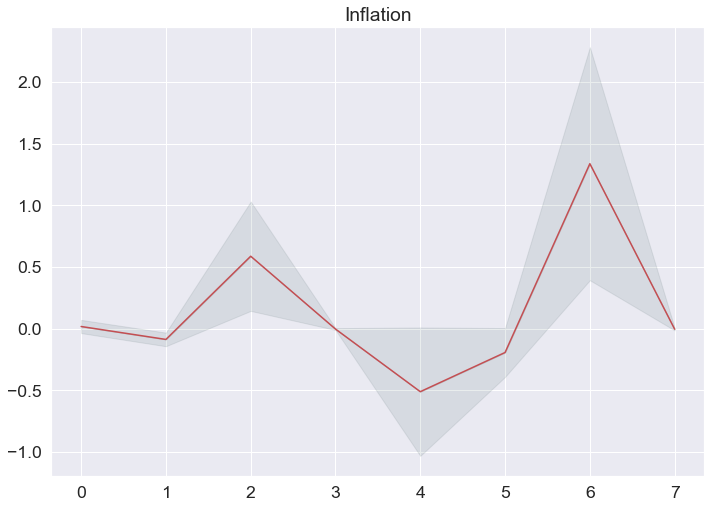

In [43]:
cumSums(res)

# Diagnostics

In [27]:
r_waldtest = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 1, 0, 0, 0],
                        [0, 0, 0, 0, 0, 1, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1]])
res.wald_test(r_waldtest)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[101.58040167]], p-value=2.0285200291706194e-18, df_denom=8>

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[63.98119972]], p-value=7.6718120666209e-11, df_denom=8>

In [18]:
r_testsum = [1, 1, 1, 1, 1, 1, 1, 1]
res.wald_test(r_testsum)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[2.29061382]], p-value=0.13015843956882603, df_denom=1>

In [51]:
t1 = [0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25, 1, 1]


In [47]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.DataFrame(np.linalg.eig(inv_weights)[0])

,0
0,10.486
1,1.628
2,0.145
3,0.049
4,0.019
5,0.010
6,0.000
7,0.001
8,0.003
9,0.003


In [49]:
t1 = np.linalg.eig(inv_weights)[0]

In [38]:
pd.corr(dataols[['Current Year', 'One Year Ahead', 'Rolling1', 'Rolling2', 'ConfFactor2']])

AttributeError: module 'pandas' has no attribute 'corr'

In [41]:
dataols[['Current Year', 'One Year Ahead', 'Rolling1', 'Rolling2', 'ConfFactor2']].corr()

,Current Year,One Year Ahead,Rolling1,Rolling2,ConfFactor2
Current Year,1.000000,0.723414,0.587760,0.643423,0.032012
One Year Ahead,0.723414,1.000000,0.821003,0.679017,-0.108606
Rolling1,0.587760,0.821003,1.000000,0.695141,-0.117598
Rolling2,0.643423,0.679017,0.695141,1.000000,-0.042604
ConfFactor2,0.032012,-0.108606,-0.117598,-0.042604,1.000000


In [59]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
dataols[['Current Year', 'One Year Ahead', 'Rolling1', 'Rolling2']].describe()

,Current Year,One Year Ahead,Rolling1,Rolling2
count,47.000,47.000,47.000,47.000
mean,-0.023,0.003,0.007,-0.001
std,0.503,0.158,0.128,0.061
min,-2.544,-0.475,-0.384,-0.207
25%,-0.138,-0.099,-0.058,-0.035
50%,0.041,0.006,0.019,0.010
75%,0.159,0.076,0.075,0.041
max,0.968,0.383,0.271,0.125


In [61]:
from scipy.stats import kurtosis
pd.DataFrame(kurtosis(dataols[['Current Year', 'One Year Ahead', 'Rolling1', 'Rolling2']], fisher=False)).T

,0,1,2,3
0,14.895,4.401,3.892,4.459


In [62]:
from scipy.stats import skew
pd.DataFrame(skew(dataols[['Current Year', 'One Year Ahead', 'Rolling1', 'Rolling2']])).T

,0,1,2,3
0,-2.666,-0.291,-0.616,-0.844
